In [1]:
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from skopt.space import Real, Categorical, Integer

from bcnf.utils import partconv1d, get_gaussian_kernel
from bcnf.utils import get_dir


In [2]:
# Define the search space
search_spaces = {
    "stage_1": {
        'condition_size': Integer(1, 2048),
        'model_hidden_size': Integer(32, 256),
        'model_n_blocks': Integer(1, 64),
        'model_act_norm': Categorical([True, False]),
        'feature_network_hidden_size': Integer(16, 2048),
        'feature_network_hidden_layers': Integer(0, 16),
        'feature_network_dropout': Real(0, 0.5),
    },
    "stage_2": {
        'condition_size': Integer(1, 2048),
        'model_nested_size': Integer(16, 1024),
        'model_nested_layers': Integer(1, 8),
        'model_n_blocks': Integer(4, 32),
        'model_act_norm': Categorical([True, False]),
        'model_dropout': Real(0.0, 0.5),
        'feature_network_hidden_size': Integer(16, 256),
        'feature_network_hidden_layers': Integer(0, 16),
        'feature_network_dropout': Real(0.0, 0.5),
    }
}

In [3]:
checkpoint_files = {
    "stage_1":  os.path.join(get_dir("models", "bcnf-models", "hyperparameter_optimization", "stage_1"), 'checkpoint.pkl'),
    "stage_2":  os.path.join(get_dir("models", "bcnf-models", "hyperparameter_optimization", "stage_2"), 'checkpoint_improved.pkl')}
metrics_dirs = {
    "stage_1": get_dir("models", "bcnf-models", "hyperparameter_optimization", "stage_1", "metrics"),
    "stage_2": get_dir("models", "bcnf-models", "hyperparameter_optimization", "stage_2", "metrics")
}

In [4]:
checkpoints = {}

for stage, checkpoint_file in checkpoint_files.items():
    with open(checkpoint_file, 'rb') as f:
        checkpoints[stage] = pickle.load(f)

In [5]:
metrics = {}

for stage, metrics_dir in metrics_dirs.items():
    metrics[stage] = {}
    for metrics_file in tqdm(os.listdir(metrics_dir)):
        with open(os.path.join(metrics_dir, metrics_file), 'rb') as f:
            metrics[stage][os.path.splitext(metrics_file)[0].replace('params_', '')] = pickle.load(f)

100%|██████████| 131/131 [00:03<00:00, 34.64it/s]


In [6]:
rows_dict = {stage: [params + [value] for params, value in zip(checkpoint['x_iters'], checkpoint['func_vals'])] for stage, checkpoint in checkpoints.items()}

In [7]:
hyper_dfs = {}

for stage, rows in rows_dict.items():
    hyper_dfs[stage] = pd.DataFrame(rows, columns=list(search_spaces[stage].keys()) + ['val_loss_upper_bound'])

    # Add the configuration name
    hyper_dfs[stage]['configuration_name'] = hyper_dfs[stage].apply(lambda row: "_".join([str(p) for p in row.values[:-1]]), axis=1)
    hyper_dfs[stage]['val_loss_mean'] = hyper_dfs[stage].apply(lambda row: np.mean([m['val_loss'][-1] for m in metrics[stage][row['configuration_name']]]) if row['configuration_name'] in metrics[stage] else None, axis=1)
    hyper_dfs[stage]['val_loss_std'] = hyper_dfs[stage].apply(lambda row: np.std([m['val_loss'][-1] for m in metrics[stage][row['configuration_name']]]) if row['configuration_name'] in metrics[stage] else None, axis=1)

    # Set all columns in 'loss' that are = 100 to nan
    hyper_dfs[stage].loc[hyper_dfs[stage]['val_loss_upper_bound'] == 100, 'val_loss_upper_bound'] = None

    # Round the values
    if 'model_dropout' in hyper_dfs[stage]:
        hyper_dfs[stage]['model_dropout'] = hyper_dfs[stage]['model_dropout'].round(3)
    hyper_dfs[stage]['feature_network_dropout'] = hyper_dfs[stage]['feature_network_dropout'].round(3)
    hyper_dfs[stage]['val_loss_upper_bound'] = hyper_dfs[stage]['val_loss_upper_bound'].round(3)

In [8]:
print(f'{hyper_dfs["stage_1"].shape[0]} configurations for stage 1')
print(f'{hyper_dfs["stage_2"].shape[0]} configurations for stage 2')

100 configurations for stage 1
100 configurations for stage 2


In [9]:
hyper_dfs["stage_1"].sort_values('val_loss_upper_bound').head(5)

,condition_size,model_hidden_size,model_n_blocks,model_act_norm,feature_network_hidden_size,feature_network_hidden_layers,feature_network_dropout,val_loss_upper_bound,configuration_name,val_loss_mean,val_loss_std
83,1402,157,14,True,88,3,0.371,-53.367,1402_157_14_True_88_3_0.37070178555757954,-54.004714,0.638082
96,1588,161,23,True,31,3,0.378,-53.291,1588_161_23_True_31_3_0.3779247177629724,-53.720357,0.429303
86,1500,155,14,True,113,3,0.392,-51.149,1500_155_14_True_113_3_0.3915854300471067,-51.729492,0.580755
68,1448,179,23,True,282,3,0.447,-50.835,1448_179_23_True_282_3_0.4471203863813682,-51.433952,0.599443
48,828,231,22,True,697,13,0.287,-50.736,828_231_22_True_697_13_0.2870257523752782,-50.944434,0.208380


In [10]:
hyper_dfs["stage_2"].sort_values('val_loss_upper_bound').head(5)

,condition_size,model_nested_size,model_nested_layers,model_n_blocks,model_act_norm,model_dropout,feature_network_hidden_size,feature_network_hidden_layers,feature_network_dropout,val_loss_upper_bound,configuration_name,val_loss_mean,val_loss_std
94,80,16,7,32,True,0.383,59,0,0.244,-61.241,80_16_7_32_True_0.3829392653521588_59_0_0.2436...,-61.495193,0.253910
69,1360,526,5,26,True,0.407,212,7,0.111,-59.355,1360_526_5_26_True_0.40716830340399_212_7_0.11...,-61.326717,1.972007
86,271,16,6,29,True,0.371,209,4,0.092,-58.231,271_16_6_29_True_0.3708844523756938_209_4_0.09...,-59.106630,0.875763
74,1714,16,4,32,True,0.209,130,5,0.031,-58.228,1714_16_4_32_True_0.20937046205957166_130_5_0....,-58.638761,0.411164
6,769,240,3,28,True,0.231,101,5,0.130,-57.694,769_240_3_28_True_0.23076923076923078_101_5_0....,-57.988298,0.294259


In [11]:
for k in hyper_dfs.keys():
    hyper_dfs[k].to_csv(os.path.join(get_dir("results", "hyperparameters", create=True), f"{k}.csv"), index=False)

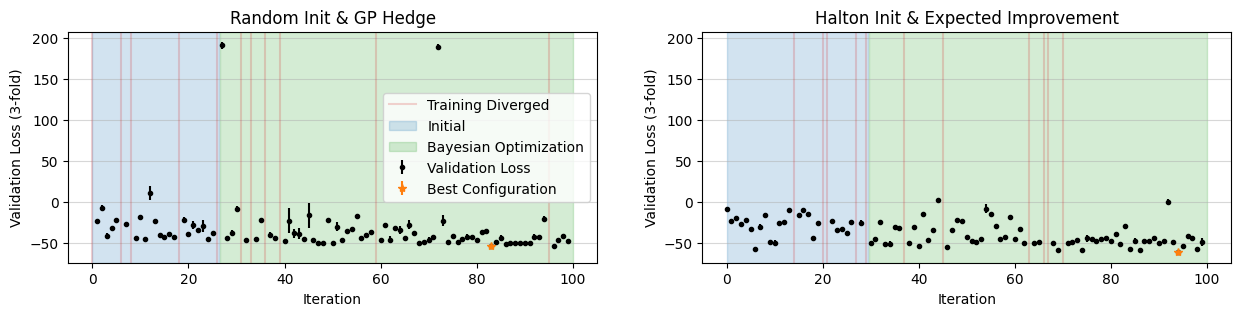

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3), sharey=True)

for ax, hyper_df, n_random_init, title in zip(axes, hyper_dfs.values(), [27, 30], ['Random Init & GP Hedge', 'Halton Init & Expected Improvement']):
    ax.errorbar(hyper_df.index, hyper_df['val_loss_upper_bound'], yerr=hyper_df['val_loss_std'], fmt='.', label='Validation Loss', color='k')

    # Plot the best configuration as a yellow star
    best_config_idx = hyper_df['val_loss_upper_bound'].idxmin()
    ax.errorbar(best_config_idx, hyper_df.loc[best_config_idx, 'val_loss_upper_bound'], yerr=hyper_df.loc[best_config_idx, 'val_loss_std'], fmt='*', label='Best Configuration', color='tab:orange')

    # Plot nan values as red vertical lines
    plotted_nan_values = False
    for i, val in enumerate(hyper_df['val_loss_upper_bound']):
        if np.isnan(val):
            ax.axvline(i, color='tab:red', alpha=0.2, label='Training Diverged' if not plotted_nan_values else None)
            # ax.axvspan(i - 0.3, i + 0.3, color='r', alpha=0.1, label='Training Diverged' if not plotted_nan_values else None)
            plotted_nan_values = True

    ax.axvspan(0, n_random_init - 0.6, color='tab:blue', alpha=0.2, label='Initial')
    ax.axvspan(n_random_init - 0.4, 100, color='tab:green', alpha=0.2, label='Bayesian Optimization')
    ax.set_title(title)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Validation Loss (3-fold)')
    ax.grid(axis='y', alpha=0.5)
    # ax.set_ylim(None, 30);

axes[0].legend()
axes[1].tick_params(axis='y', which='both', left=True, labelleft=True)

In [13]:
best_configuration = hyper_dfs["stage_2"].sort_values('val_loss_upper_bound').iloc[0]['configuration_name']

Text(0.5, 0.98, '80_16_7_32_True_0.3829392653521588_59_0_0.2436754429557059')

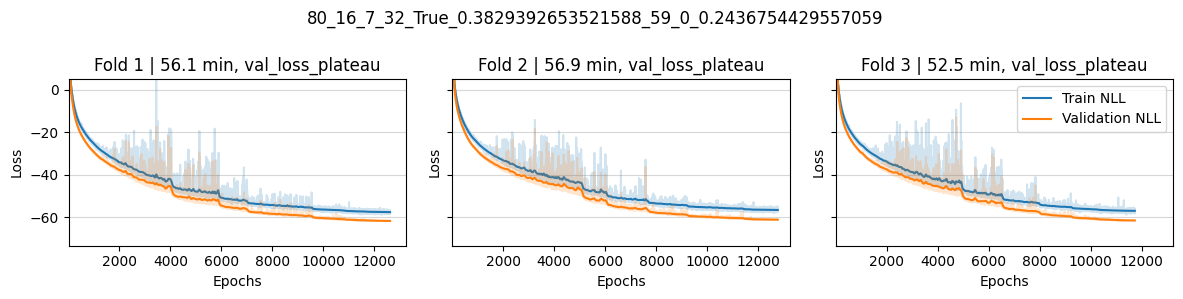

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True, sharex=True)

for i, ax in enumerate(axes):
    loss_history = metrics["stage_2"][best_configuration][i]['loss_history']
    epochs = np.array([e for e, _ in loss_history['train']])
    losses = np.array([l for _, l in loss_history['train']])

    ax.plot(epochs, losses, alpha=0.2, color='C0')
    ax.plot(epochs, partconv1d(losses, kernel=get_gaussian_kernel(sigma=128)), label='Train NLL', color='C0')

    epochs = np.array([e for e, _ in loss_history['val']])
    losses = np.array([l for _, l in loss_history['val']])

    ax.plot(epochs, losses, alpha=0.2, color='C1')
    ax.plot(epochs, partconv1d(losses, kernel=get_gaussian_kernel(sigma=32)), label='Validation NLL', color='C1')

    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')

    # ax.set_xscale('log')
    ax.set_ylim(None, 5)
    ax.set_xlim(1, None)
    ax.grid(axis='y', alpha=0.5)

    time_taken = loss_history['time'][-1][1] - loss_history['time'][0][1]
    ax.set_title(f'Fold {i+1} | {time_taken / 60:.1f} min, {loss_history["stop_reason"]}')

axes[-1].legend();

fig.tight_layout()
fig.subplots_adjust(top=0.75)
fig.suptitle(best_configuration)

In [15]:
hyper_dfs.keys()

dict_keys(['stage_1', 'stage_2'])

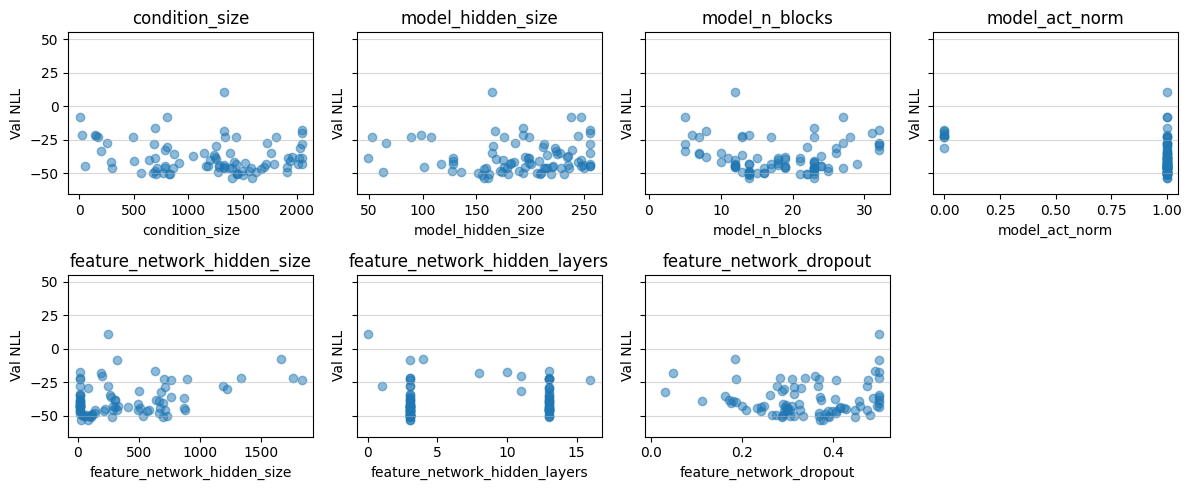

In [16]:
# Scatter the 'val_loss_upper_bound' column against the other columns
COLS = 4
ROWS = np.ceil(len(search_spaces["stage_1"]) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 2.5), sharey=True)

for i, (col, ax) in enumerate(zip(search_spaces["stage_1"].keys(), axes.flatten())):
    ax.scatter(hyper_dfs["stage_1"][col], hyper_dfs["stage_1"]['val_loss_upper_bound'], alpha=0.5)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel('Val NLL')
    ax.grid(axis='y', alpha=0.5)
    ax.set_ylim(None, 55)

for ax in axes.flatten()[len(search_spaces["stage_1"]):]:
    ax.remove()

fig.tight_layout()

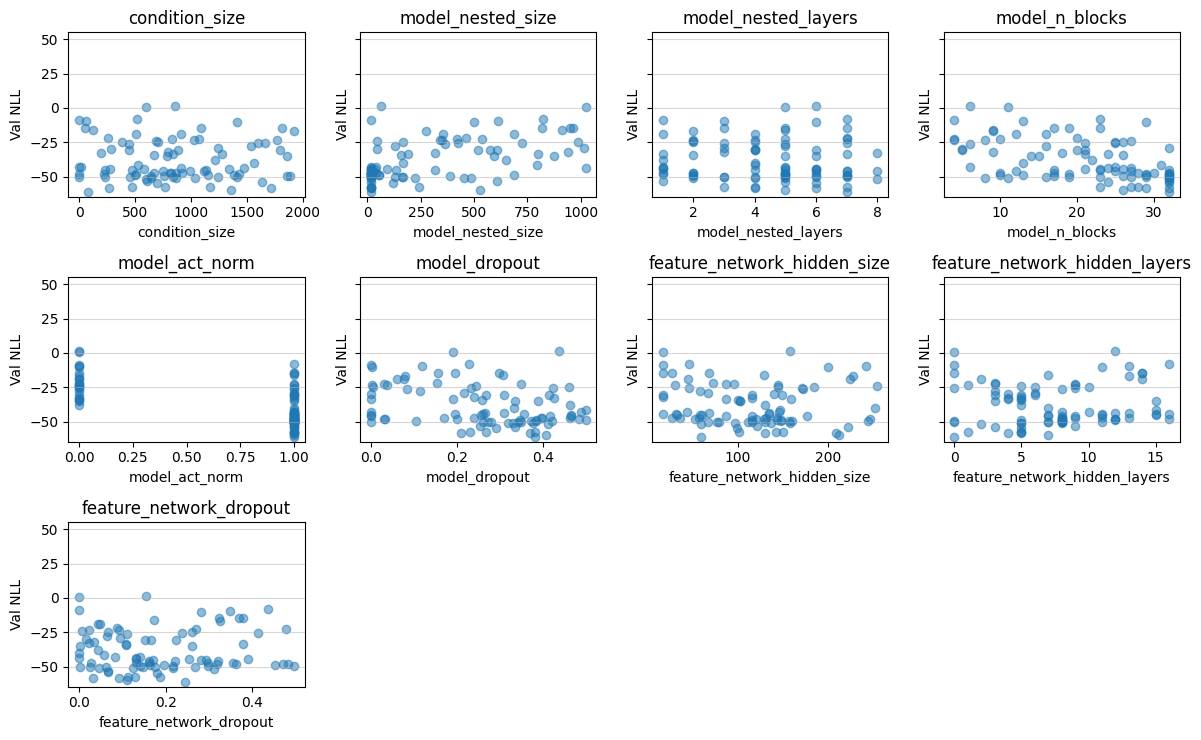

In [17]:
# Scatter the 'val_loss_upper_bound' column against the other columns
COLS = 4
ROWS = np.ceil(len(search_spaces["stage_2"]) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 2.5), sharey=True)

for i, (col, ax) in enumerate(zip(search_spaces["stage_2"].keys(), axes.flatten())):
    ax.scatter(hyper_dfs["stage_2"][col], hyper_dfs["stage_2"]['val_loss_upper_bound'], alpha=0.5)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel('Val NLL')
    ax.grid(axis='y', alpha=0.5)
    ax.set_ylim(None, 55)

for ax in axes.flatten()[len(search_spaces["stage_2"]):]:
    ax.remove()

fig.tight_layout()